In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  4 11:40:07 2018

@author: weizhong
"""
#数据集 PDNA-224-ONEHOT-11-N.mat PDNA-224-ONEHOT-11-P.mat 

import scipy.io as sio
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

#数据集相关常数
DATA_SIZE = 7556
INPUT_NODE = 460
OUTPUT_NODE = 2
X_SIZE = 23
Y_SIZE = 20
NUM_CHANNELS = 1
NUM_LABELS = 2

#配置神经网络的参数
#第一层卷积层的尺寸和深度
CONV1_DEEP = 32
CONV1_SIZE = 5
#第二层卷积层的尺寸和深度
CONV2_DEEP = 64
CONV2_SIZE = 5

FC_SIZE = 1024 #全连接层的节点个数

BATCH_SIZE = 50 #

LEARNING_RATE = 1e-4 #基础学习率

LEANING_RATE_DECAY = 0.99 #学习率的衰减率

TRAINING_STEPS= 2000 #训练轮数

#不同类的惩罚系数
LOSS_COEF = [100, 1]

#初始化权值
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=1,seed=1) #生成一个截断的正态分布
    return tf.Variable(initial)
    #return tf.Variable(tf.zeros(shape))

#初始化偏置
def bias_variable(shape):
    initial = tf.truncated_normal(shape,stddev=1,seed=1)
    return tf.Variable(initial)
    #return tf.Variable(tf.zeros(shape))

#卷积层
def conv2d(x,W):
    #input tensor of shape [batch, in_height, in_width, in_channels]
    #filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]
    #strides[0]=strides[3]=1. strides[1]代表ｘ方向的步长，strids[2]代表ｙ方向的步长
    #padding: A string from "SAME", "VALID"
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

#池化层
def max_pool(x):
    #ksize [1,x,y,1]
    return tf.nn.max_pool(x,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def cnn(x_train, x_test, y_train, y_test):
    x_train_size = np.size(x_train, 0)
    #定义两个placeholder
    x = tf.placeholder(tf.float32, [None, INPUT_NODE])#23*20
    y = tf.placeholder(tf.float32, [None, OUTPUT_NODE])

    #改变x的格式转为４Ｄ的向量【batch, in_height, in_width, in_channels]
    x_image = tf.reshape(x,[-1, X_SIZE, Y_SIZE, 1])

    #初始化第一个卷积层的权值和偏量
    W_conv1 = weight_variable([CONV1_SIZE,CONV1_SIZE,NUM_CHANNELS,CONV1_DEEP])#5*5的采样窗口，３２个卷积核从4个平面抽取特征
    b_conv1 = bias_variable([CONV1_DEEP])#每一个卷积核一个偏置值

    #把x_image和权值向量进行卷积，再加上偏置值，然后应用于relu激活函数
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool(h_conv1)#进行max-pooling,12-by-40

    #初始化第二个卷积层的权值和偏置
    W_conv2 = weight_variable([CONV2_SIZE,CONV2_SIZE,CONV1_DEEP,CONV2_DEEP]) #5*5的采样窗口，64个卷积核从32个平面抽取特征
    b_conv2 = bias_variable([CONV2_DEEP]) #每一个卷积核一个偏置值

    #把H_pool1和权值向量进行卷积，再加上偏置值，然后应用于relu激活函数
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool(h_conv2)#6-by-5

    #23*20的图片第一次卷积后还是23*20,第一次池化后变为12*10
    #第二次卷积后为12*10,第二次池化后变为6*5
    #进过上面操作后得到64张6*5的平面

    #初始化第一全链接层的权值
    W_fc1 = weight_variable([6*5*CONV2_DEEP,FC_SIZE]) #上一层有6*10*64个神经元,全连接层有1024个神经元
    b_fc1 = bias_variable([FC_SIZE])

    #把池化层2的输出扁平化为1维
    h_pool2_flat = tf.reshape(h_pool2,[-1,6*5*CONV2_DEEP])
    #求第一个全连接层的输出
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #keep_prob用了表示神经元的输出概率
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    #初始化第二个全连接层
    W_fc2 = weight_variable([FC_SIZE,OUTPUT_NODE])
    b_fc2 = bias_variable([OUTPUT_NODE])

    #计算输出
    prediction = tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2) + b_fc2)
    # 结果存放在一个布尔列表中
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    #交叉熵代价函数
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=prediction))
    #使用AdamOptimizer进行优化
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
    
#     #自定义损失函数，因为结合位点的标签是[0,1]共有3778，非结合位点的标签是[1,0]有53570，是非平衡数据集，
#     cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=prediction)
#     y1 = tf.argmax(y,1)
#     yshape = tf.shape(y)
#     a = tf.ones([yshape[0]],dtype=tf.int64)
#     loss = tf.reduce_mean( tf.where( tf.greater_equal( y1,a), cross_entropy * LOSS_COEF[1], cross_entropy * LOSS_COEF[0]))

#     #使用AdamOptimizer进行优化
#     train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    #求准确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(TRAINING_STEPS):
            start = (i * BATCH_SIZE) % x_train_size
            end = min(start + BATCH_SIZE, x_train_size)
            batch_xs = x_train[start:end]
            batch_ys = y_train[start:end]
            sess.run(train_step,feed_dict={x:batch_xs, y: batch_ys, keep_prob: 0.5})
        print(sess.run(accuracy, feed_dict={x:x_test, y:y_test, keep_prob:1.0}))
        pred = sess.run(prediction, feed_dict={x: x_test, y: y_test, keep_prob: 1.0})
        return pred


# 绘制混淆矩阵的函数
# 参数1  cm 混淆矩阵中显示的数值 二维数组
# 参数2 cmap 混淆矩阵中的颜色
# 参数3 title 标题
def plot_confusion_matrix(cm, classes, title='混淆矩阵', cmap=plt.cm.Greens):
    # imshow() 表示绘制并显示二维图 有18个参数
    # 参数1 X 混淆矩阵中显示的数值 二维数组
    # 参数2 cmap 颜色 plt.cm.Blues表示蓝色 plt.cm.Reds表示红色 plt.cm.Greens表示绿色
    # 参数5 interpolation 插值法 一般有如下值
    #     nearest 最近邻插值法
    #     bilinear 双线性插值法
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.imshow(cm, cmap=cmap, interpolation="nearest")
    plt.title(title)  # 标题
    plt.colorbar()  # 显示颜色的进度条
    tick_marks = np.arange(2)  # [0 1]
    plt.xticks(tick_marks, classes)  # 对x轴上分类进行标记
    plt.yticks(tick_marks, classes)  # 对y轴上分类进行标记

    thresh = np.mean(cm)
    for i in range(2):
        for j in range(2):
            plt.text(i, j, cm[j][i],
                     horizontalalignment='center',
                     color='white' if cm[i][j] >= thresh else 'black')

    plt.xlabel('预测值')
    plt.ylabel('真实值')


    
    
#load benchmark dataset
N_data = sio.loadmat('PDNA-224-ONEHOT-11-N.mat')
P_data = sio.loadmat('PDNA-224-ONEHOT-11-P.mat')
n_X = N_data['n_data']
n_Y = N_data['n_target']
print(len(n_Y))
print('')

p_X = P_data['p_data']
p_Y = P_data['p_target']
print(len(p_Y))

# X = n_X[0:3778]+p_X
# Y = n_Y[0:3778]+p_Y

X = np.vstack((n_X[0:3778],p_X))
Y = np.vstack((n_Y[0:3778],p_Y))




range_data=list(range(DATA_SIZE))    #python3  range函数中需要加list
#print(range_data)

#rind = random.shuffle(range_data)
random.shuffle(range_data)
#print(rind)
#print(range_data)
pred_Y = np.ndarray([DATA_SIZE,OUTPUT_NODE])

X = X.reshape(DATA_SIZE,-1)
X = X[range_data]
Y = Y[range_data]




kf = KFold(n_splits=5)
kf.get_n_splits(X)
#print(X)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("len(X_train)={},len(Y_test)={}".format(len(X_train),len(Y_test)))
    pred_Y[test_index] = cnn(X_train,X_test,Y_train,Y_test)

    
    
correct = 0
for i in range(DATA_SIZE):
    if (Y[i] == pred_Y[i]).all():
        correct += 1
print("correct accuracy: {}".format(correct/DATA_SIZE))

Y1 = np.ndarray([DATA_SIZE])
PY = np.ndarray([DATA_SIZE])
for i in range(DATA_SIZE):
    if Y[i][0] == 1:
        Y1[i] = 0
    else:
        Y1[i] = 1
    
    if pred_Y[i][0] == 1:
        PY[i] = 0
    else:
        PY[i] = 1
cnf_matrix = confusion_matrix(Y1, PY)

print(cnf_matrix)
recall = cnf_matrix[1][1] / (cnf_matrix[1][0] + cnf_matrix[1][1])
print('recall: ', recall)
plot_confusion_matrix(cnf_matrix, [0, 1], cmap=plt.cm.Reds)
plt.show()

53570

3778
0.48677248
0.51224357
0.48246196
0.5056254
0.49636003
correct accuracy: 0.49642668078348334
[[2230 1548]
 [2255 1523]]
recall:  0.4031233456855479


<Figure size 640x480 with 2 Axes>

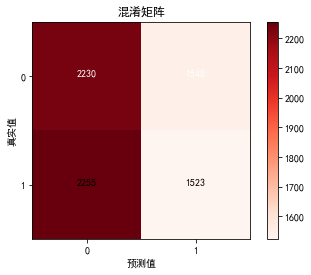

In [3]:
plot_confusion_matrix(cnf_matrix, [0, 1], cmap=plt.cm.Reds)
plt.show()